# Full Neural Network Setup

*run on ds6*

In [26]:
# library dependencies
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import lzma
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow as tf
import keras_tuner
import math
import time
import gc

In [2]:
# method to store data as serialized binary structure lzma compressed
def can_pickles(data, filename):
    with lzma.LZMAFile(filename, 'wb') as f:
        pickle.dump(data, f, pickle.DEFAULT_PROTOCOL)

# method to retrieve data from a compressed pickle file (created with the method above)
def uncan_pickles(filename):
    with lzma.LZMAFile(filename, 'rb') as f:
        return pickle.load(f)

In [3]:
# helper method to create a valid dataset
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

# method to create a TF dataset
def create_dataset(X1_np_array, X2_np_array, y_np_array, batch_size=32, sort=False):
    # sort the arrays
    if sort == True:
        # build an array containing the sequence lengths
        sequence_lengths = list(map(lambda x: len(x), X1_np_array))
        # sort the array but only get the indices
        sorted_indices = np.argsort(sequence_lengths)
        # now sort the X and y train arrays according to the sorted indicds
        X1_np_array = X1_np_array[sorted_indices]
        X2_np_array = X2_np_array[sorted_indices]
        y_np_array = y_np_array[sorted_indices]

    # create ragged tensor from in-homogeneous array
    # using .constant is incredibly slow, even slower with parameters
    # ie. 100 samples take 7 seconds, with parameters it takes 11 seconds
    # using the following method that seems nuts it's a speedup for the previous example to 0.02 seconds
    # X_tensor = tf.ragged.constant(X1_np_array, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
    # https://github.com/tensorflow/tensorflow/issues/47853
    X_tensor = tf.RaggedTensor.from_row_lengths(
        values=tf.concat(X1_np_array.tolist(), axis=0),
        row_lengths=[len(a) for a in X1_np_array]
    )
    
    # create dataset
    ds = tf.data.Dataset.from_tensor_slices(({'inputs_1': X_tensor, 'inputs_2': X2_np_array}, y_np_array))

    # create a dataset of dense tensors
    ds = ds.map(reformat)

    # apply padded batching to the dataset
    ds = ds.padded_batch(batch_size)
    
    return ds

In [49]:
# method to plot two MAE arrays
def plot_loss(train_mae, val_mae, start_epoch=1):
    # get the number of epochs the training ran
    epochs = range(start_epoch, len(train_mae) + 1)
    # plot the graph
    plt.plot(epochs, train_mae[start_epoch - 1:], "bo", label="Training")
    plt.plot(epochs, val_mae[start_epoch - 1:], "b", label="Validation")
    plt.title("Training and Validation Mean Absolute Error")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

In [5]:
# model to work with
# from keras-tuner run:
#   conv_units: 424
#   kernel_size: 30
#   rate: 0.30000000000000004
#   dense_units: 128
def augur_model():
    inputs_1 = layers.Input(shape=(None, 10), name='inputs_1')
    
    conv1 = layers.Conv1D(
        filters=424,
        kernel_size=30,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs_1)
    norm1 = layers.BatchNormalization()(conv1)
    drop1 = layers.Dropout(
        rate=0.3
    )(norm1)
    pool1 = layers.GlobalMaxPool1D()(drop1)
    # flat = layers.Flatten()(pool1)

    inputs_2 = layers.Input(shape=(29,), name='inputs_2')

    conc = layers.Concatenate(axis=1)([pool1, inputs_2])
    
    dense = layers.Dense(128, activation='relu')(conc)
    outputs = layers.Dense(1)(dense)
    
    model = keras.Model(inputs=[inputs_1, inputs_2], outputs=outputs, name='Test')

    return model

In [6]:
def dan_zrimec_model():
    inputs_1 = layers.Input(shape=(None, 10), name='inputs_1')
    
    # 1D convolution
    conv = layers.Conv1D(
        filters=280,
        kernel_size=12, 
        strides=1, 
        activation='relu'
    )(inputs_1)
    # batch normalization
    norm = layers.BatchNormalization()(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(norm)
    # dropout
    drop = layers.Dropout(
        rate=0.15
    )(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=448, 
            return_sequences=True, 
            recurrent_dropout=0.3
        ),
        merge_mode='concat'
        # input_shape=(8000, 4),
    )(drop)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(bilstm)
    drop = layers.Dropout(
        rate=0.1
    )(pool)
    # flatten
    # flat = layers.Flatten()(drop)
    gmp = layers.GlobalMaxPool1D()(drop)

    inputs_2 = layers.Input(shape=(29,), name='inputs_2')

    conc = layers.Concatenate(axis=1)([gmp, inputs_2])
    
    # fully connected
    dense = layers.Dense(
        units=128,
        activation='relu',
    )(conc)
    # batch normalization
    norm = layers.BatchNormalization()(dense)
    # dropout
    drop = layers.Dropout(
        rate=0.45
    )(norm)
    # dense
    outputs = layers.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=[inputs_1, inputs_2], outputs=outputs, name='FullModel')

    return model

In [42]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [45]:
def run_model(model, train_ds, val_ds, epochs=10, start_epoch=1, oneshot=True, verbose=True):
    if verbose: 
        model.summary()
        verbose_fit = 'auto'
    else:
        verbose_fit = 0
    
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.MeanAbsoluteError()],
    )

    bar_callback = keras.callbacks.BackupAndRestore(backup_dir='./bar', save_freq='epoch')
        
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        verbose=verbose_fit,
        callbacks=[GarbageCollectorCallback(), bar_callback]
    )
    
    if oneshot == True:
        plot_loss(
            history.history['mean_absolute_error'],
            history.history['val_mean_absolute_error'],
            start_epoch
        )

    if val_ds != None:
        return history.history['mean_absolute_error'], history.history['val_mean_absolute_error']
    else:
        return history.history['mean_absolute_error']

In [8]:
# simple timer from https://realpython.com/python-timer/

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            print(f"Timer is running. Use .stop() to stop it")
        else:
            self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
        else:
            elapsed_time = time.perf_counter() - self._start_time
            self._start_time = None
            print(f"    elapsed time: {elapsed_time:0.4f} seconds")

## Data Prep

*explain it in more detail*

X holds a list of sequences one hot encoded

y holds a list of PTR values as floats

In [28]:
# read the prepared data back
X1_raw = uncan_pickles('../data/multihot_x1.pickle.xz')
X2 = uncan_pickles('../data/multihot_x2.pickle.xz')
y = uncan_pickles('../data/multihot_y.pickle.xz')

In [29]:
# refined numpy array build with smaller memory footprint
X1 = np.empty(len(X1_raw), dtype=object)
for id, seq in enumerate(X1_raw):
  X1[id] = np.array(seq, dtype=np.int8)

In [30]:
# build an inhomogenous numpy array from X
# X1 = np.array(X1, dtype=object)
X2 = np.array(X2, dtype=np.int8)

In [31]:
# convert type of target values from string to float
y = np.array(y, dtype=np.float32)

Random sample from X and y.

In [13]:
X1[0]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int8)

In [14]:
X2[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [15]:
y[0]

8.277

In [16]:
# count of features and labels
len(X1), len(X2), len(y)

(214853, 214853, 214853)

### Baseline PTR

There is no common sense approach in finding a baseline for the protein-to-mRNA ratio of a particular mRNA sequence. This is what the *Basic Neural Network* approach is for - to determin a baseline and see if a slightly adapted neural network with feature engineered input can provide better predictions.

But what can be done is to simply check the value range of the target PTRs, calculate mean and standard deviation. Given that the standard deviation is  small (12.5% of the value range) one can (stupidly) predict the mean value every time. From that it's possible to calculate the Mean Absolute Error (MAE) and compare that to the following neural network output.

In [17]:
# get some idea of the range of the PTR in the selected SAMPLE
print(np.min(y), np.max(y), np.mean(y), np.std(y))

0.9085 9.974 4.9798956 0.8879484


In [18]:
# simple/dumb baseline mean absolute error of always predicting 4.974
mae = np.mean(np.abs(np.array(y) - 4.974))
mae

0.7119917

### Splits

Split data in train and test sub sets

In [32]:
# split in train and test sub sets
X1_train_full, X1_test, X2_train_full, X2_test, y_train_full, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=1202)

In [33]:
# split the training set again in train and validation
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1_train_full, X2_train_full, y_train_full, test_size=0.2, random_state=1202)

In [34]:
batch_size = 64

In [35]:
%%time
# build the test dataset
test_ds = create_dataset(X1_test, X2_test, y_test, batch_size=batch_size, sort=False)

CPU times: user 4.07 s, sys: 142 ms, total: 4.21 s
Wall time: 801 ms


In [36]:
%%time
# build the training dataset
train_full_ds = create_dataset(X1_train_full, X2_train_full, y_train_full, batch_size=batch_size, sort=True)

CPU times: user 3.52 s, sys: 23.5 s, total: 27 s
Wall time: 3.26 s


In [37]:
%%time
# build the training dataset
train_ds = create_dataset(X1_train, X2_train, y_train, batch_size=batch_size, sort=True)

CPU times: user 3.03 s, sys: 18.6 s, total: 21.6 s
Wall time: 2.77 s


In [38]:
%%time
# build the validation dataset
val_ds = create_dataset(X1_val, X2_val, y_val, batch_size=batch_size, sort=False)

CPU times: user 3.65 s, sys: 102 ms, total: 3.75 s
Wall time: 979 ms


In [ ]:
# NOT doing that any more since the speed up of the ragged tensor creation

# save the previously generated dataset
# since the ragged tensor creation takes a very, very long time
# test_ds.save('../data/test_ds.tf.dataset')
# train_full_ds.save('../data/train_full_ds.tf.dataset')
# train_ds.save('../data/train_ds.tf.dataset')
# val_ds.save('../data/val_ds.tf.dataset')

## Full Model Training

training model for 40
Model: "Test"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs_1 (InputLayer)       [(None, None, 10)]           0         []                            
                                                                                                  
 conv1d_7 (Conv1D)           (None, None, 424)            127624    ['inputs_1[0][0]']            
                                                                                                  
 batch_normalization_6 (Bat  (None, None, 424)            1696      ['conv1d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 dropout_6 (Dropout)         (None, None, 424)            0         ['bat

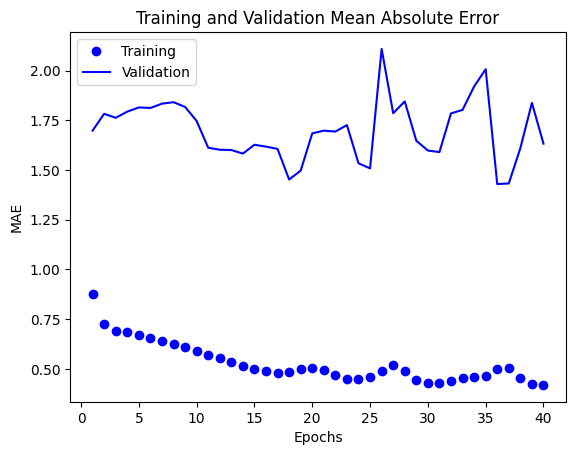

    elapsed time: 63025.4187 seconds


In [43]:
# epochs to run for
epochs = 40

# timer
t = Timer()

# current model
model = augur_model()
# fit the model, validate and plot results
print(f'training model for {epochs}')
t.start()
mae, val_mae = run_model(model, train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=True, verbose=True)
t.stop()

In [44]:
augur_mae = mae
augur_val_mae = val_mae

In [48]:
# train final model

# model file name
model_name = 'model_full_augur.keras'

# timer
t = Timer()

# number of epochs to train for
epochs = 37

print(f'training final model {model_name} for {epochs} epochs')

print('  building model')
model = augur_model()

print('  training model')
t.start()
run_model(model, train_full_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_full_augur.keras for 37 epochs
  building model
  training model
    elapsed time: 66046.5175 seconds
  evaluating model
672/672 [==============================] - 100s 149ms/step - loss: 3.1555 - mean_absolute_error: 1.6659
  mean absolute evaluation error is [3.1555373668670654, 1.6658642292022705]
  saving model


training model for 40
Model: "FullModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs_1 (InputLayer)       [(None, None, 10)]           0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, None, 280)            33880     ['inputs_1[0][0]']            
                                                                                                  
 batch_normalization_4 (Bat  (None, None, 280)            1120      ['conv1d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling1d_4 (MaxPoolin  (None, None, 280)            0         

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2149/2149 [==============================] - 16628s 8s/step - loss: 0.5330 - mean_absolute_error: 0.5736 - val_loss: 0.6237 - val_mean_absolute_error: 0.6249
Epoch 28/40
2149/2149 [==============================] - 16618s 8s/step - loss: 0.5172 - mean_absolute_error: 0.5642 - val_loss: 0.7081 - val_mean_absolute_error: 0.6476
Epoch 29/40
2149/2149 [==============================] - 16643s 8s/step - loss: 0.5071 - mean_absolute_error: 0.5585 - val_loss: 0.6590 - val_mean_absolute_error: 0.6275
Epoch 30/40
2149/2149 [==============================] - 16609s 8s/step - loss: 0.4968 - mean_absolute_error: 0.5521 - val_loss: 0.5790 - val_mean_absolute_error: 0.5908
Epoch 31/40
1706/2149 [======================>.......] - ETA: 37:32 - loss: 0.4911 - mean_absolute_error: 0.5477

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2149/2149 [==============================] - 16627s 8s/step - loss: 0.4812 - mean_absolute_error: 0.5428 - val_loss: 0.7773 - val_mean_absolute_error: 0.7022
Epoch 33/40
2149/2149 [==============================] - 16614s 8s/step - loss: 0.4741 - mean_absolute_error: 0.5387 - val_loss: 1.2184 - val_mean_absolute_error: 0.9026
Epoch 34/40
2149/2149 [==============================] - 16613s 8s/step - loss: 0.4681 - mean_absolute_error: 0.5354 - val_loss: 0.5826 - val_mean_absolute_error: 0.5971
Epoch 35/40
2149/2149 [==============================] - 16606s 8s/step - loss: 0.4632 - mean_absolute_error: 0.5322 - val_loss: 1.3114 - val_mean_absolute_error: 0.9625
Epoch 36/40
2149/2149 [==============================] - 16621s 8s/step - loss: 0.4575 - mean_absolute_error: 0.5287 - val_loss: 1.1437 - val_mean_absolute_error: 0.8965
Epoch 37/40
2149/2149 [==============================] - 16609s 8s/step - loss: 0.4522 - mean_absolute_error: 0.5256 - val_loss: 0.7413 - val_mean_absolute_error:

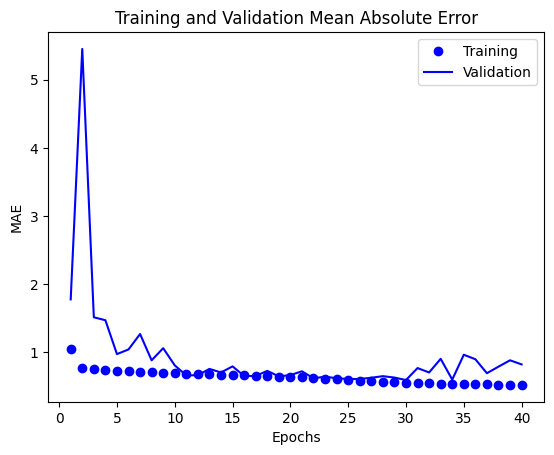

    elapsed time: 666066.2232 seconds


In [46]:
# epochs to run for
epochs = 40

# timer
t = Timer()

# current model
model = dan_zrimec_model()
# fit the model, validate and plot results
print(f'training model for {epochs}')
t.start()
mae, val_mae = run_model(model, train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=True, verbose=True)
t.stop()

In [47]:
dz_mae = mae
dz_val_mae = val_mae

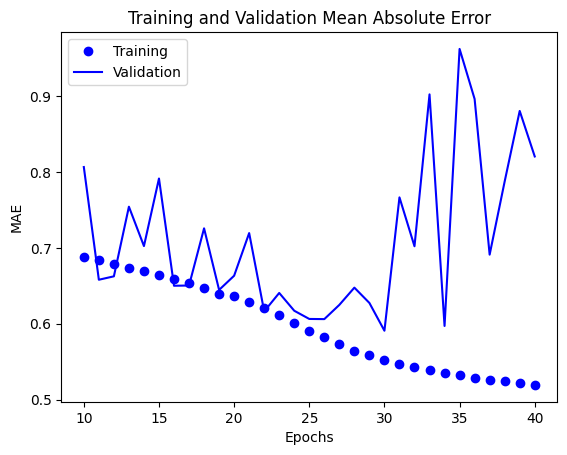

In [50]:
plot_loss(mae, val_mae, 10)

In [52]:
# train final model

# model file name
model_name = 'model_full_dz.keras'

# timer
t = Timer()

# number of epochs to train for
epochs = 30

print(f'training final model {model_name} for {epochs} epochs')

print('  building model')
model = dan_zrimec_model()

print('  training model')
t.start()
run_model(model, train_full_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_full_dz.keras for 30 epochs
  building model
  training model
    elapsed time: 512773.1618 seconds
  evaluating model
672/672 [==============================] - 3147s 5s/step - loss: 0.5939 - mean_absolute_error: 0.5876
  mean absolute evaluation error is [0.5939379334449768, 0.5876457691192627]
  saving model


## k-Fold Cross Validation

In [ ]:
num_splits = 5

### Augur Model

In [ ]:
%%time
# run k-fold cross validation

# epochs to run for
epochs = 100

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(augur_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [ ]:
# train final model

# model file name
model_name = 'model_augur.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 40

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = augur_model()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

In [ ]:
%%time
# run k-fold cross validation

# epochs to run for
epochs = 100

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(dan_zrimec_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [ ]:
%%time
# run k-fold cross validation

# epochs to run for
epochs = 100

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(dan_zrimec_model2(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)